# Algoritimo Genético

# 1. Introdução

Olá! Meu nome é joão luiz, integrante do Grupo 30 da pos graduação IA para Devs 2025.

Na Fase 2 Apresento esse projeto de Algoritimo Genético focado em distribuir alunos em turmas, buscando o equilíbrio de atributos como:

Primeira letra do nome (PrimeiraLetra)
Procedência (Procedencia)
Sexo (Sexo)
Idade (Idade)


```
Edher                - RM361040
Yago Marialva        - RM361884
João Sá              - RM363107
Franclin             - RM364871
Pavão                - RM364496
```

## Importação biblioteca

In [3]:
import numpy as np
import pandas as pd
import pygad
from prettytable import PrettyTable

from itertools import repeat, chain
from collections import defaultdict, Counter
import random

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white", palette=None)

from ga import obtenha_alunos
from ga import calcula_penalidade


ModuleNotFoundError: No module named 'pygad'

## Preparação dos dados

In [ ]:
df = pd.read_csv('alunos.csv')

maximo_alunos_por_turma = 25 #Esse é a proporção ideal para que uma turma não fique completamente cheia e que permita depois novos alunos poderão ser enturmados
total_alunos = df.Nome.count()
numero_turmas = int(np.ceil(total_alunos / maximo_alunos_por_turma))
total_alunos_por_turma_distribuida = int(np.ceil(total_alunos / numero_turmas))
ocupacao_maxima = int(numero_turmas * maximo_alunos_por_turma) #Esse é o número máximo de alunos se todas as turmas estivessem preenchidas com o máximo permitido
ocupacao_total_turmas = total_alunos_por_turma_distribuida * numero_turmas

print(f"Informações iniciais encontradas nos dados:")
print(f"Total de alunos: {total_alunos}")
print(f"Quantidade de turmas: {numero_turmas}")
print(f"Quantidade de alunos por turma: {total_alunos_por_turma_distribuida}") 
print(f"Ocupação turmas: {ocupacao_total_turmas}") 
print(f"Ocupação máxima total: {ocupacao_maxima}")

Informações iniciais encnotradas nos dados:
Total de alunos: 119
Quantidade de turmas: 5
Quantidade de alunos por turma: 24
Ocupação turmas: 120
Ocupação máxima total: 125


### Uma análise para cada restrição

In [ ]:
df_agrupado_primeira_letra = df.groupby('PrimeiraLetra')['PrimeiraLetra'].agg([
    ('Contagem', 'count'),
    ('MinimoTurma', lambda x: np.floor(x.count() / numero_turmas)),
    ('MaximoTurma', lambda x: np.ceil(x.count() / numero_turmas)),
]).reset_index()
df_agrupado_primeira_letra

,PrimeiraLetra,Contagem,MinimoTurma,MaximoTurma
0,A,10,2.0,2.0
1,B,4,0.0,1.0
2,C,7,1.0,2.0
3,D,8,1.0,2.0
4,E,5,1.0,1.0
5,F,5,1.0,1.0
6,G,8,1.0,2.0
7,H,11,2.0,3.0
8,I,4,0.0,1.0
9,J,10,2.0,2.0


In [ ]:
df_agrupado_procedencia = df.groupby('Procedencia')['Procedencia'].agg([
    ('Contagem', 'count'),
    ('MinimoTurma', lambda x: np.floor(x.count() / numero_turmas)),
    ('MaximoTurma', lambda x: np.ceil(x.count() / numero_turmas)),
]).reset_index()
df_agrupado_procedencia

,Procedencia,Contagem,MinimoTurma,MaximoTurma
0,1,2,0.0,1.0
1,132,2,0.0,1.0
2,254,8,1.0,2.0
3,289,5,1.0,1.0
4,368,74,14.0,15.0
5,380,1,0.0,1.0
6,385,2,0.0,1.0
7,31577,2,0.0,1.0
8,32342,1,0.0,1.0
9,501263,1,0.0,1.0


In [ ]:
df_agrupado_sexo = df.groupby('Sexo')['Sexo'].agg([
    ('Contagem', 'count'),
    ('MinimoTurma', lambda x: np.floor(x.count() / numero_turmas)),
    ('MaximoTurma', lambda x: np.ceil(x.count() / numero_turmas)),
]).reset_index()
df_agrupado_sexo

,Sexo,Contagem,MinimoTurma,MaximoTurma
0,F,43,8.0,9.0
1,M,76,15.0,16.0


In [ ]:
df_agrupado_idade = df.groupby('Idade')['Idade'].agg([
    ('Contagem', 'count'),
    ('MinimoTurma', lambda x: np.floor(x.count() / numero_turmas)),
    ('MaximoTurma', lambda x: np.ceil(x.count() / numero_turmas)),
])
df_agrupado_idade

,Contagem,MinimoTurma,MaximoTurma
Idade,,,
9,1,0.0,1.0
10,2,0.0,1.0
11,84,16.0,17.0
12,32,6.0,7.0


## Calculando os pisos e tetos para montar as penalidades com base nos mínimos e máximos de cada restrição

In [ ]:
grupo_sexo = df.groupby('Sexo')['Sexo'].value_counts().to_dict()
grupo_pl = df.groupby('PrimeiraLetra')['PrimeiraLetra'].value_counts().to_dict()
grupo_procedencia = df.groupby('Procedencia')['Procedencia'].value_counts().to_dict()
grupo_idade = df.groupby('Idade')['Idade'].value_counts().to_dict()

grupo_sexo_pt = {k: [int(np.floor(v / numero_turmas)), int(np.ceil(v / numero_turmas))] for k, v in grupo_sexo.items()}
grupo_pl_pt = {k: [int(np.floor(v / numero_turmas)), int(np.ceil(v / numero_turmas))] for k, v in grupo_pl.items()}
grupo_procedencia_pt = {k: [int(np.floor(v / numero_turmas)), int(np.ceil(v / numero_turmas))] for k, v in grupo_procedencia.items()}
grupo_idade_pt = {k: [int(np.floor(v / numero_turmas)), int(np.ceil(v / numero_turmas))] for k, v in grupo_idade.items()}

print(f"Sexo: {grupo_sexo}")
print(f"Idade: {grupo_idade}")
print(f"Procedencia: {grupo_procedencia}")
print(f"Primeira letra: {grupo_pl}\n")

print(grupo_sexo_pt)
print(grupo_pl_pt)
print(grupo_procedencia_pt)
print(grupo_idade_pt)

Sexo: {'F': 43, 'M': 76}
Idade: {9: 1, 10: 2, 11: 84, 12: 32}
Procedencia: {1: 2, 132: 2, 254: 8, 289: 5, 368: 74, 380: 1, 385: 2, 31577: 2, 32342: 1, 501263: 1, 501334: 4, 501421: 1, 501446: 14, 501503: 1, 501592: 1}
Primeira letra: {'A': 10, 'B': 4, 'C': 7, 'D': 8, 'E': 5, 'F': 5, 'G': 8, 'H': 11, 'I': 4, 'J': 10, 'K': 1, 'L': 15, 'M': 17, 'O': 1, 'P': 5, 'R': 1, 'T': 3, 'V': 3, 'Y': 1}

{'F': [8, 9], 'M': [15, 16]}
{'A': [2, 2], 'B': [0, 1], 'C': [1, 2], 'D': [1, 2], 'E': [1, 1], 'F': [1, 1], 'G': [1, 2], 'H': [2, 3], 'I': [0, 1], 'J': [2, 2], 'K': [0, 1], 'L': [3, 3], 'M': [3, 4], 'O': [0, 1], 'P': [1, 1], 'R': [0, 1], 'T': [0, 1], 'V': [0, 1], 'Y': [0, 1]}
{1: [0, 1], 132: [0, 1], 254: [1, 2], 289: [1, 1], 368: [14, 15], 380: [0, 1], 385: [0, 1], 31577: [0, 1], 32342: [0, 1], 501263: [0, 1], 501334: [0, 1], 501421: [0, 1], 501446: [2, 3], 501503: [0, 1], 501592: [0, 1]}
{9: [0, 1], 10: [0, 1], 11: [16, 17], 12: [6, 7]}


## População inicial

In [ ]:
alunos_tuplas = list(df.itertuples(index=False,name='Aluno'))

# Completa a lista com None, representando cadeiras vazias nas turmas
lista_completa_alunos = list(chain(
    alunos_tuplas,
    repeat(None, ocupacao_total_turmas - len(alunos_tuplas))
))

In [ ]:
individuo1 = list(range(0, ocupacao_total_turmas))
individuo2 = list(range(0, ocupacao_total_turmas))
individuo3 = list(range(0, ocupacao_total_turmas))
individuo4 = list(range(0, ocupacao_total_turmas))
random.shuffle(individuo1)
random.shuffle(individuo2)
random.shuffle(individuo3)
random.shuffle(individuo4)

print(individuo1)
print(individuo2)
print(individuo3)
print(individuo4)

initial_population = [individuo1, individuo2, individuo3, individuo4]

[27, 21, 47, 3, 24, 33, 109, 44, 65, 30, 85, 12, 80, 40, 118, 48, 119, 101, 37, 50, 99, 6, 53, 73, 96, 114, 79, 41, 113, 110, 15, 46, 20, 51, 34, 7, 64, 60, 9, 71, 108, 78, 1, 59, 75, 106, 86, 69, 10, 82, 63, 94, 49, 4, 17, 89, 107, 56, 13, 52, 16, 25, 84, 88, 36, 70, 26, 95, 112, 23, 111, 83, 0, 104, 57, 29, 39, 14, 76, 98, 74, 97, 45, 77, 105, 67, 32, 115, 54, 62, 72, 81, 92, 117, 66, 100, 87, 18, 68, 28, 31, 22, 42, 11, 5, 91, 43, 102, 38, 90, 19, 103, 61, 93, 35, 2, 116, 55, 8, 58]
[43, 66, 38, 84, 13, 54, 21, 69, 98, 112, 81, 64, 115, 92, 8, 95, 53, 19, 88, 75, 29, 86, 17, 47, 79, 27, 108, 114, 14, 105, 110, 101, 45, 42, 104, 52, 51, 5, 25, 62, 87, 76, 3, 65, 116, 22, 89, 4, 37, 26, 80, 103, 41, 40, 18, 70, 23, 90, 61, 82, 71, 93, 11, 83, 35, 34, 58, 94, 2, 56, 59, 44, 102, 63, 0, 1, 10, 107, 117, 74, 85, 32, 57, 99, 96, 30, 31, 15, 7, 113, 12, 119, 68, 91, 73, 28, 109, 9, 111, 100, 78, 49, 72, 106, 48, 60, 39, 33, 67, 118, 16, 36, 6, 20, 24, 77, 97, 50, 46, 55]
[3, 61, 30, 22, 74

In [ ]:
def calcula_penalidades(alunos_turma, sexo_pt, pl_pt, procedencia_pt, idade_pt):
    qtd_sexo = Counter([aluno.Sexo for aluno in alunos_turma])
    qtd_letras = Counter([aluno.PrimeiraLetra for aluno in alunos_turma])
    qtd_procedencia = Counter([aluno.Procedencia for aluno in alunos_turma])
    qtd_idade = Counter([aluno.Idade for aluno in alunos_turma])        
    return [calcula_penalidade(qtd_sexo, sexo_pt), calcula_penalidade(qtd_letras, pl_pt), calcula_penalidade(qtd_procedencia, procedencia_pt), calcula_penalidade(qtd_idade, idade_pt)]

def fitness_func(ga_instance, solution, solution_idx):
    turmas_solution = np.reshape(solution, newshape=(numero_turmas, total_alunos_por_turma_distribuida))
    penalidades_total = 0
    for turma in turmas_solution:
        alunos_turma = obtenha_alunos(lista_completa_alunos, turma)
        penalidades = np.sum(calcula_penalidades(alunos_turma, grupo_sexo_pt, grupo_pl_pt, grupo_procedencia_pt, grupo_idade_pt))
        penalidades_total += penalidades
    return 1 / penalidades_total

In [ ]:
num_generations = 150000
num_parents_mating = 2

sol_per_pop = 2
num_genes = ocupacao_total_turmas
init_range_low = 0
init_range_high = ocupacao_total_turmas
gene_space = [i for i in range(0, ocupacao_total_turmas)]

parent_selection_type = "rank"
keep_parents = 2 
crossover_type = "single_point" 

mutation_type = "swap" 
mutation_percent_genes = 20


c:\Python313\Lib\site-packages\pygad\visualize\plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


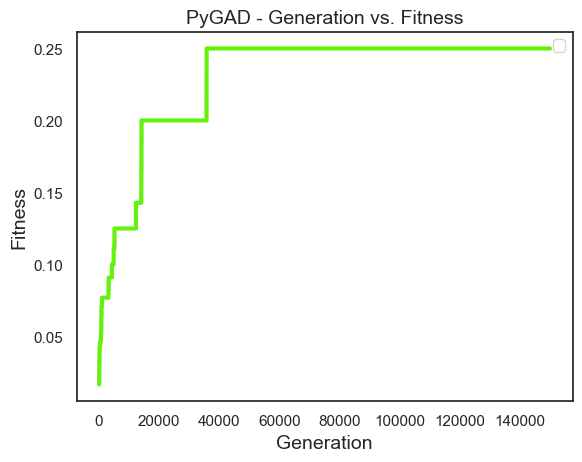

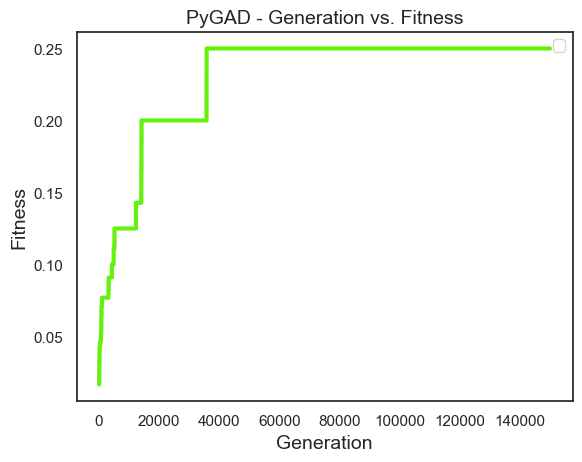

In [ ]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       initial_population=initial_population,
                       gene_space = gene_space,
                       fitness_func=fitness_func,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False,
                       gene_type=int)

ga_instance.run()

ga_instance.plot_fitness()

In [ ]:
individuo = ga_instance.best_solution()[0]
turmas = np.reshape(individuo, newshape=(numero_turmas, total_alunos_por_turma_distribuida))

In [ ]:
lst_sexo = []
lst_letras = []
lst_idade = []
lst_procedencia = []

indice_turma = 1
for turma in turmas:
    alunos_turma = obtenha_alunos(lista_completa_alunos, turma)
    qtd_letras = Counter([aluno.PrimeiraLetra for aluno in alunos_turma])
    qtd_sexo = Counter([aluno.Sexo for aluno in alunos_turma])
    qtd_procedencia = Counter([aluno.Procedencia for aluno in alunos_turma])
    qtd_idade = Counter([aluno.Idade for aluno in alunos_turma])
    for k in qtd_sexo:
        lst_sexo.append({'Turma': indice_turma, 'Sexo': k, 'Quantidade': qtd_sexo[k]})
    for k in qtd_letras:
        lst_letras.append({'Turma': indice_turma, 'Letra': k, 'Quantidade': qtd_letras[k]})
    for k in qtd_idade:
        lst_idade.append({'Turma': indice_turma, 'Idade': k, 'Quantidade': qtd_idade[k]})
    for k in qtd_procedencia:
        lst_procedencia.append({'Turma': indice_turma, 'Procedencia': k, 'Quantidade': qtd_procedencia[k]})

    indice_turma += 1

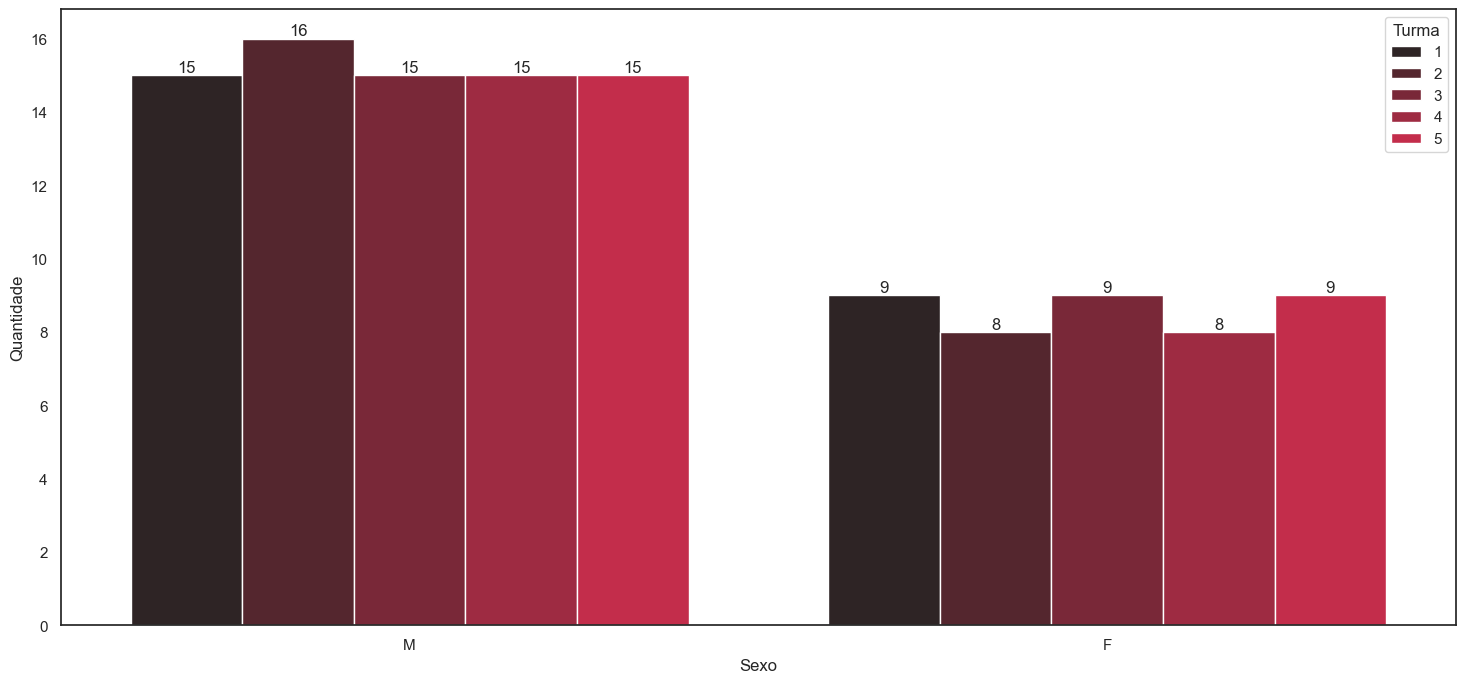

In [ ]:
plt.figure(figsize=(18, 8))
df_sexo = pd.DataFrame(data=lst_sexo)
ax = sns.barplot(x = 'Sexo', y = 'Quantidade', hue = 'Turma', data = df_sexo, palette='dark:crimson')
for container in ax.containers:
    ax.bar_label(container)

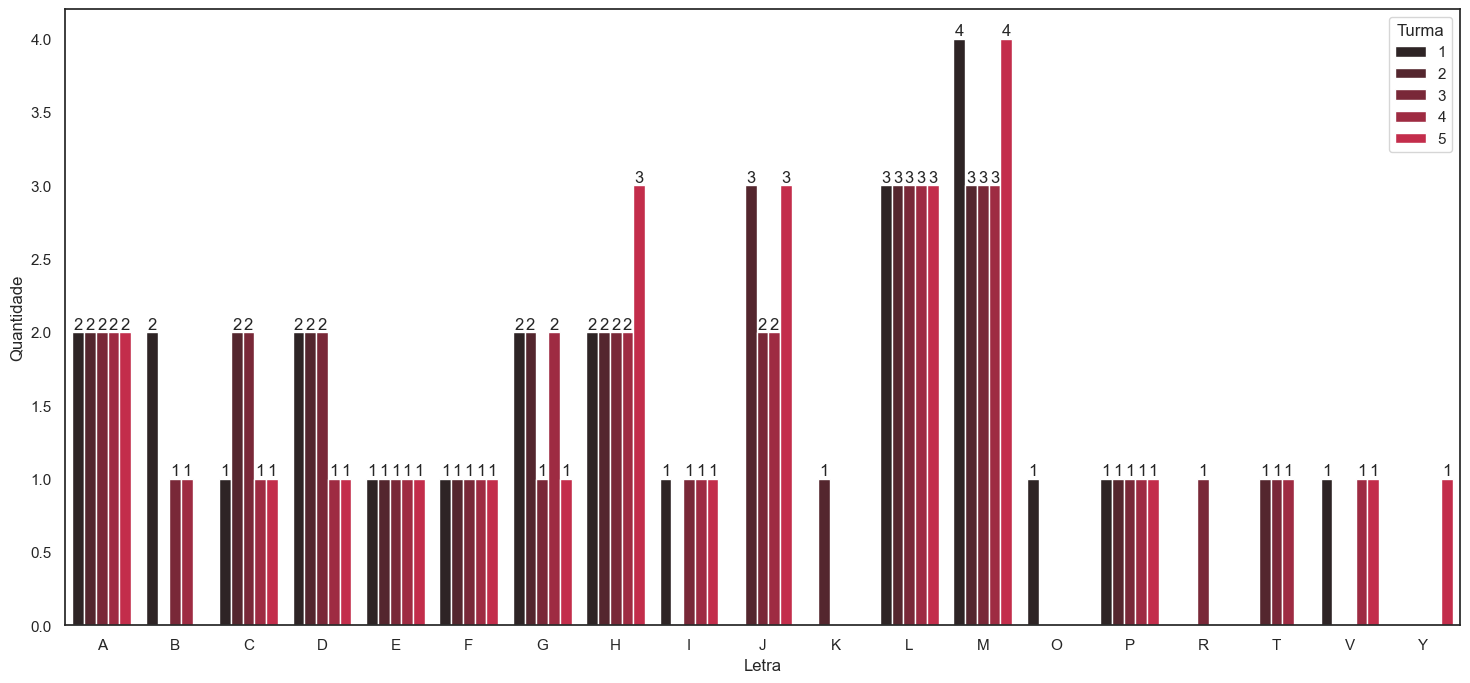

In [ ]:
plt.figure(figsize=(18, 8))
df_letras = pd.DataFrame(data=lst_letras)
df_letras.sort_values(by=['Letra'], inplace=True)
ax = sns.barplot(x = 'Letra', y = 'Quantidade', hue = 'Turma', data = df_letras, palette='dark:crimson')
for container in ax.containers:
    ax.bar_label(container)

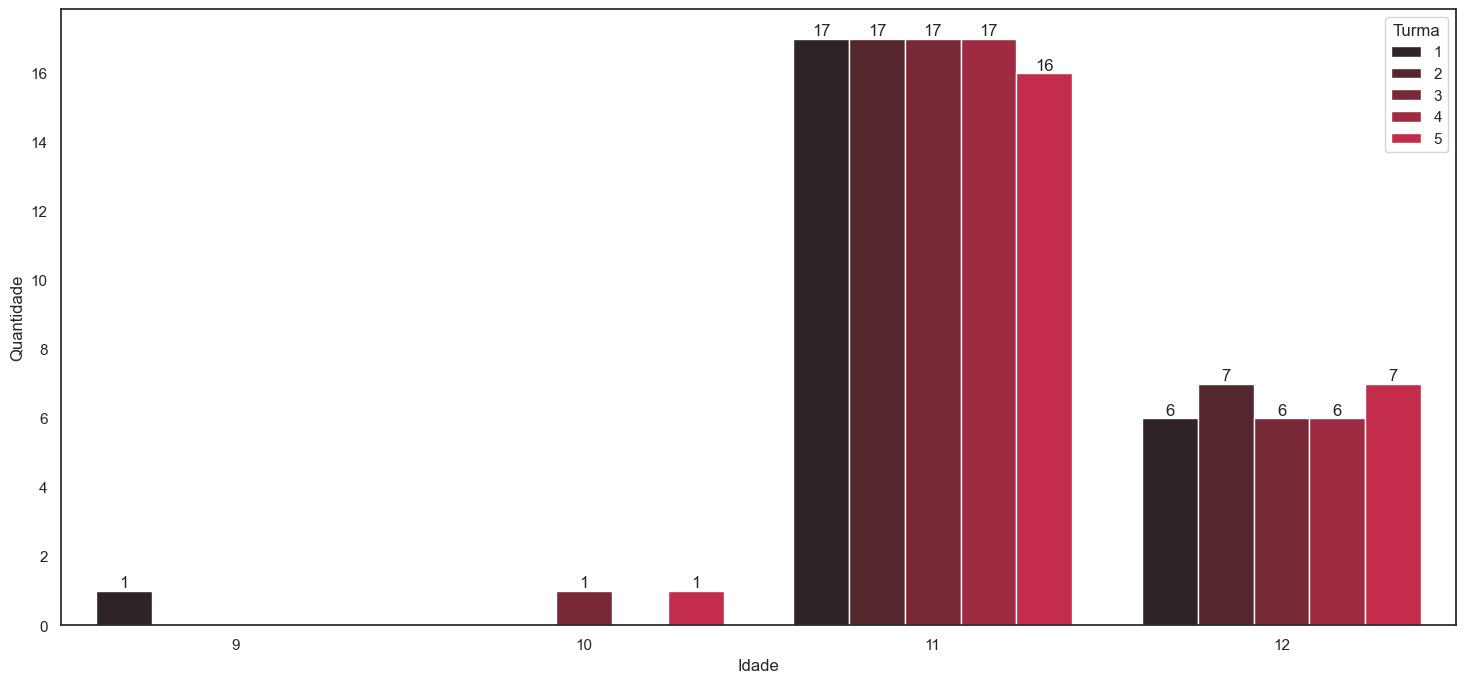

In [ ]:
plt.figure(figsize=(18, 8))
df_idade = pd.DataFrame(data=lst_idade)
df_idade.sort_values(by=['Idade'], inplace=True)
ax = sns.barplot(x = 'Idade', y = 'Quantidade', hue = 'Turma', data = df_idade, palette='dark:crimson')
for container in ax.containers:
    ax.bar_label(container)

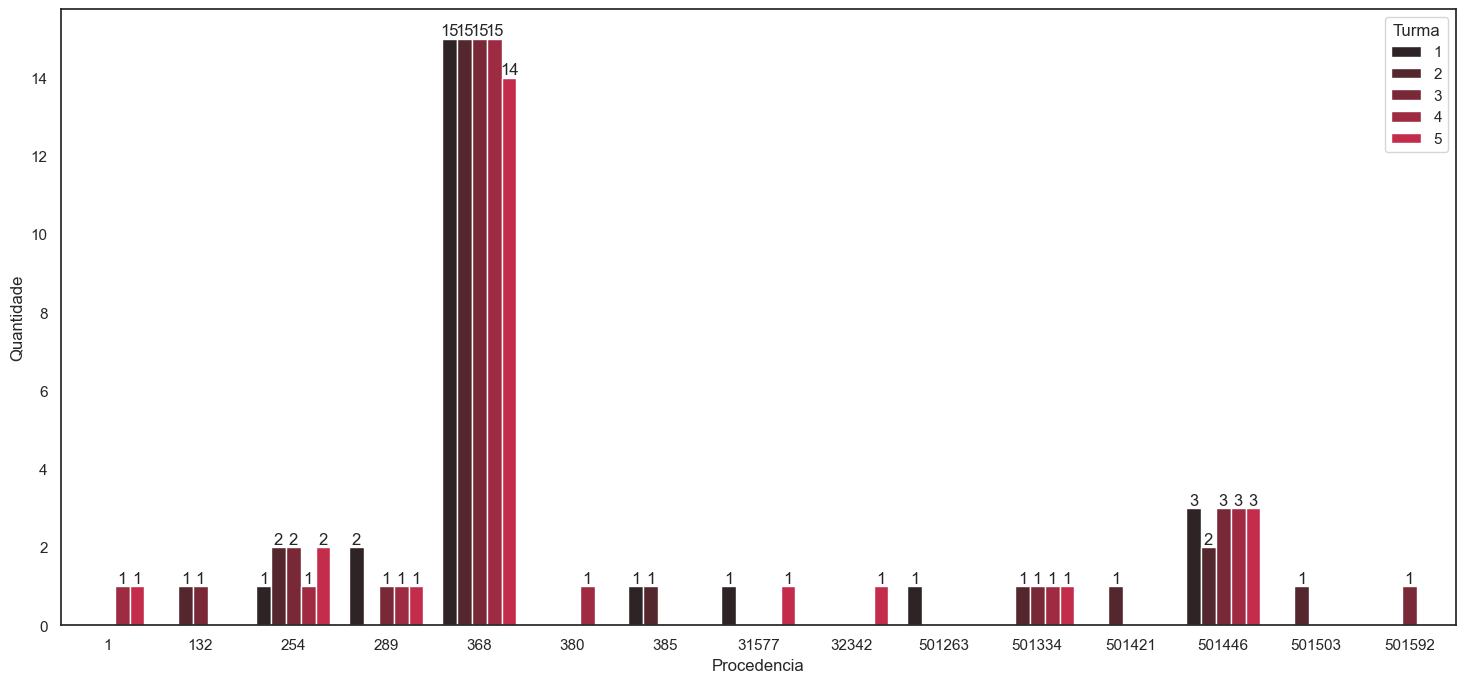

In [ ]:
plt.figure(figsize=(18, 8))
df_procedencia = pd.DataFrame(data=lst_procedencia)
df_procedencia.sort_values(by=['Procedencia'], inplace=True)
ax = sns.barplot(x = 'Procedencia', y = 'Quantidade', hue = 'Turma', data = df_procedencia, palette='dark:crimson')
for container in ax.containers:
    ax.bar_label(container)